In [ ]:
import torch
from detanet_model import nn_vib_analysis,Lorenz_broadening,DetaNet,get_raman_intensity,uv_model,nmr_calculator,nmr_sca,charge_model

In [3]:
device=torch.device('cpu')
dtype=torch.float32

In [4]:
'''
The spectrum calculation modules of DetaNet consists of a tensor of the shape [Num_atom,3] 
indicating the position of the atom and a LongTensor of [Num_atom] indicating the element type.
Here, we take the example of Phenol
'''
pos=torch.tensor([[ 9.7233e-02,  1.3689e+00,  1.3115e-01],
        [ 6.7777e-02,  3.2910e-03,  3.8910e-02],
        [ 7.6066e-02, -6.6728e-01, -1.1832e+00],
        [ 4.4743e-02, -2.0582e+00, -1.2085e+00],
        [ 5.2200e-03, -2.7850e+00, -2.4071e-02],
        [-2.7410e-03, -2.1055e+00,  1.1924e+00],
        [ 2.8234e-02, -7.1819e-01,  1.2309e+00],
        [ 1.2295e-01,  1.7542e+00, -7.5192e-01],
        [ 1.0686e-01, -1.0483e-01, -2.1109e+00],
        [ 5.1425e-02, -2.5716e+00, -2.1622e+00],
        [-1.9064e-02, -3.8668e+00, -4.6867e-02],
        [-3.3378e-02, -2.6606e+00,  2.1220e+00],
        [ 2.2412e-02, -1.7973e-01,  2.1697e+00]],device=device,dtype=dtype)

z=torch.LongTensor([8, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1])

pos.shape,z.shape

(torch.Size([13, 3]), torch.Size([13]))

In [7]:
'''Loading model'''
charge_model_=charge_model(device=device)
vib_model=nn_vib_analysis(device=device,Linear=False,scale=0.965)
nmr_model=nmr_calculator(device=device)
uv_model_=uv_model(device=device)

charge_model_

/media/maria/work_space/capsule-3259363/code/detanet_model/model_loader.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict=torch.load(params)
/media/maria/work_

DetaNet(
  (Embedding): Embedding(
    (act): Swish()
    (elec_emb): Linear(in_features=16, out_features=128, bias=False)
    (nuclare_emb): Embedding(10, 128)
    (ls): Linear(in_features=128, out_features=128, bias=True)
  )
  (Radial): Radial_Basis(
    (radial): Bessel_Function()
  )
  (blocks): Sequential(
    (0): Interaction_Block(
      (message): Message(
        (Attention): Edge_Attention(
          (actq): Swish()
          (actk): Swish()
          (actv): Swish()
          (acta): Swish()
          (softmax): Softmax(dim=-1)
          (lq): Linear(in_features=128, out_features=128, bias=True)
          (lk): Linear(in_features=128, out_features=128, bias=True)
          (lv): Linear(in_features=128, out_features=256, bias=True)
          (la): Linear(in_features=256, out_features=256, bias=True)
          (lrbf): Linear(in_features=32, out_features=128, bias=False)
          (lkrbf): Linear(in_features=128, out_features=128, bias=False)
          (lvrbf): Linear(in_featu

In [8]:
'''Caculation of atomic charge'''

charge=charge_model_(z=z, pos=pos)

charge

ImportError: 'radius_graph' requires 'torch-cluster'

In [6]:
'''Calculation of frequency, IR intensity, Raman activity for each vibration mode. (Units are consistent with Gaussian G16)'''
freq,iir,araman=vib_model(z=z, pos=pos)
for i in range(len(freq)):
    print('Vibration mode:{},Frequency:{:.8f},IR intensity:{:.8f},Raman activity:{:.8f}'
       .format(i+1,freq[i].item(),iir[i].item(),araman[i].item()))

Vibration mode:1,Frequency:234.93322754,IR intensity:60.03249741,Raman activity:0.68421316
Vibration mode:2,Frequency:240.97119141,IR intensity:54.97920990,Raman activity:3.35584497
Vibration mode:3,Frequency:389.43374634,IR intensity:0.05184007,Raman activity:0.02404398
Vibration mode:4,Frequency:404.78552246,IR intensity:11.11933994,Raman activity:0.31459305
Vibration mode:5,Frequency:489.18408203,IR intensity:0.88136709,Raman activity:0.09773882
Vibration mode:6,Frequency:521.72937012,IR intensity:2.17807412,Raman activity:5.84700775
Vibration mode:7,Frequency:613.24005127,IR intensity:5.68167257,Raman activity:0.09091721
Vibration mode:8,Frequency:615.38885498,IR intensity:0.36473665,Raman activity:5.46547699
Vibration mode:9,Frequency:758.73791504,IR intensity:92.44653320,Raman activity:0.05366646
Vibration mode:10,Frequency:784.02569580,IR intensity:8.61820507,Raman activity:0.02411912
Vibration mode:11,Frequency:803.38812256,IR intensity:22.74972725,Raman activity:17.50065422
Vi

In [7]:
'''Broadening of frequency and intensity'''
x_axis=torch.linspace(500, 4000, 3501)
yir=Lorenz_broadening(freq,iir,c=x_axis,sigma=15).detach().numpy()

yraman_act=Lorenz_broadening(freq,araman,c=x_axis,sigma=12)

#get raman intensity from raman act,frequency
yraman=get_raman_intensity(x_axis,yraman_act).detach().numpy()

x=x_axis.detach().numpy()

In [8]:
from matplotlib import pyplot as plt
%matplotlib notebook
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np
plt.rcParams['axes.unicode_minus'] = False  
plt.rcParams['xtick.direction'] = 'in'  # 
plt.rcParams['ytick.direction'] = 'in' 

<IPython.core.display.Javascript object>


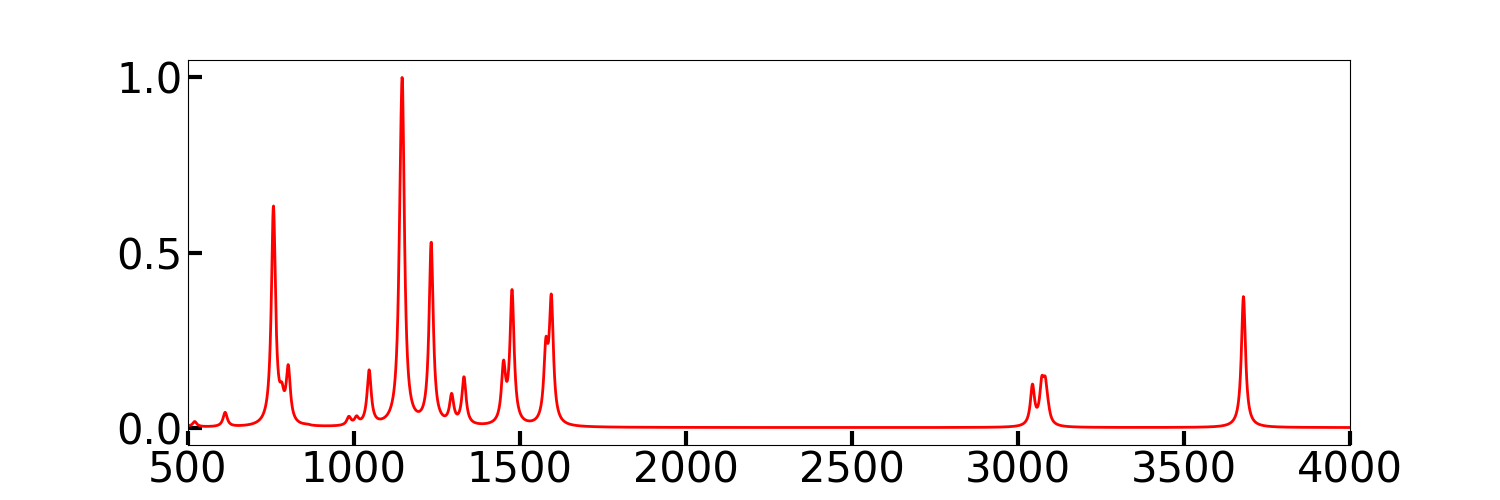

In [9]:
'''draw ir spectrum'''
plt.figure(figsize=(15,5))
plt.rc('font',family='Times New Roman', size=30)
plt.plot(x,yir/yir.max(),lw=2,label='IR',color='r')
plt.xlim(500,4000)
plt.tick_params(labelsize=30,width=3,length=10)
plt.show()

<IPython.core.display.Javascript object>


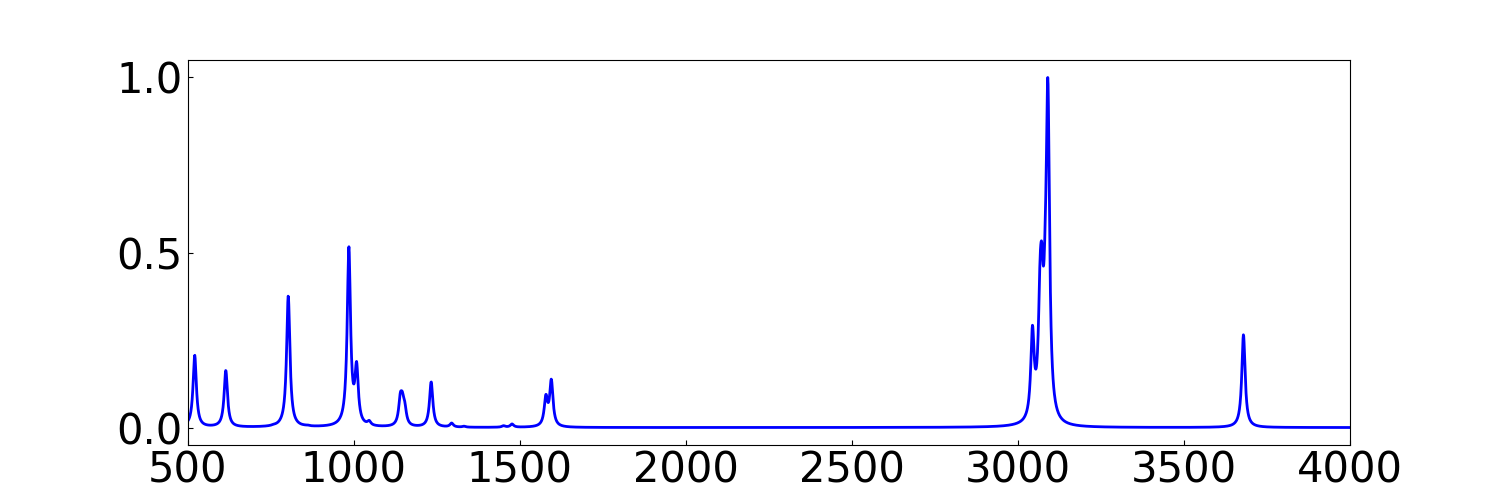

In [10]:
'''draw raman spectrum'''
plt.figure(figsize=(15,5))
plt.rc('font',family='Times New Roman', size=30)
plt.xlim(500,4000)
plt.plot(x,yraman/yraman.max(),lw=2,label='Raman',color='blue')

In [11]:
'''Calculate NMR Shift of C and H atom'''
sc,sh=nmr_model(pos=pos,z=z)

sc,sh

(tensor([[163.2916],
         [117.0862],
         [134.3739],
         [124.6024],
         [135.7667],
         [120.1776]], grad_fn=<AddBackward0>),
 tensor([[3.3317],
         [6.6368],
         [7.3450],
         [6.9707],
         [7.3930],
         [7.1397]], grad_fn=<AddBackward0>))

In [12]:
'''Aggregation of hydrogen and carbon from the same chemical environment
in index,all hydrogen atoms and carbon atoms in the same chemical environment are represented by same number
    
'''
indexc=torch.LongTensor([0,1,2,3,2,1])
indexh=torch.LongTensor([0,1,2,3,2,1])
shiftc,intc,shifth,inth=nmr_sca(sc.reshape(-1),sh.reshape(-1),indexc,indexh)

In [13]:
'''Broadening of nmr shift and intensity'''
xh=torch.linspace(0, 12, 1201)
xc=torch.linspace(0,300,3001)
yc=Lorenz_broadening(shiftc,intc,c=xc,sigma=1).detach().numpy()
yh=Lorenz_broadening(shifth,inth,c=xh,sigma=0.05).detach().numpy()

<IPython.core.display.Javascript object>


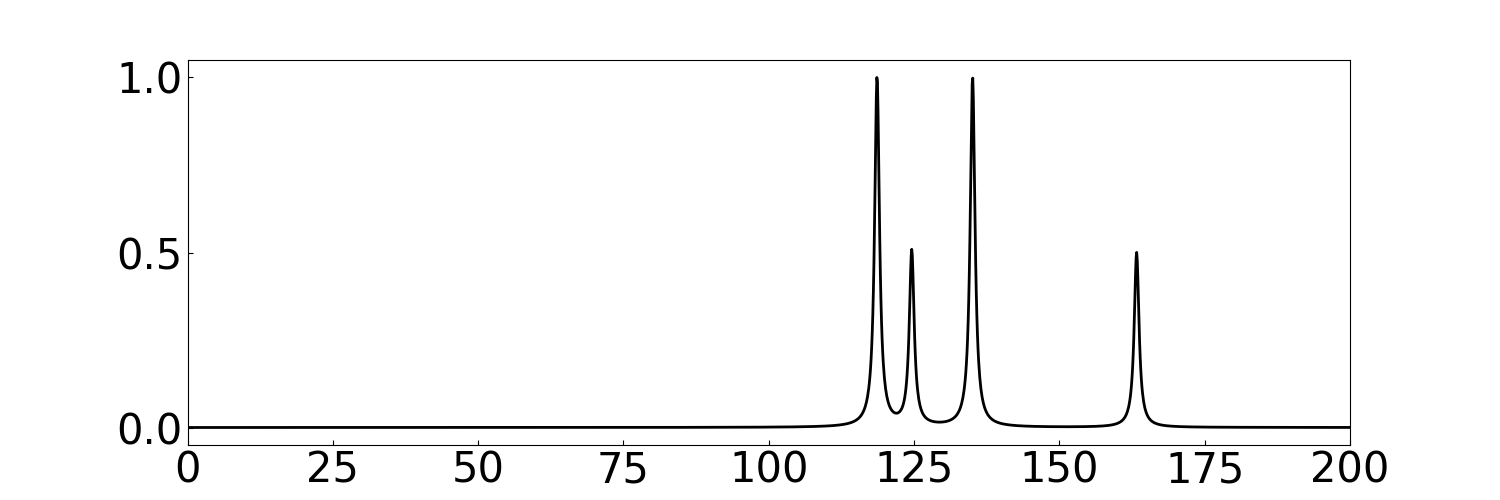

In [14]:
'''draw nmrc spectrum'''
plt.figure(figsize=(15,5))
plt.xlim(0,200)
plt.plot(xc,yc/yc.max(),lw=2,label='NMRC13',color='black')
plt.show()

<IPython.core.display.Javascript object>


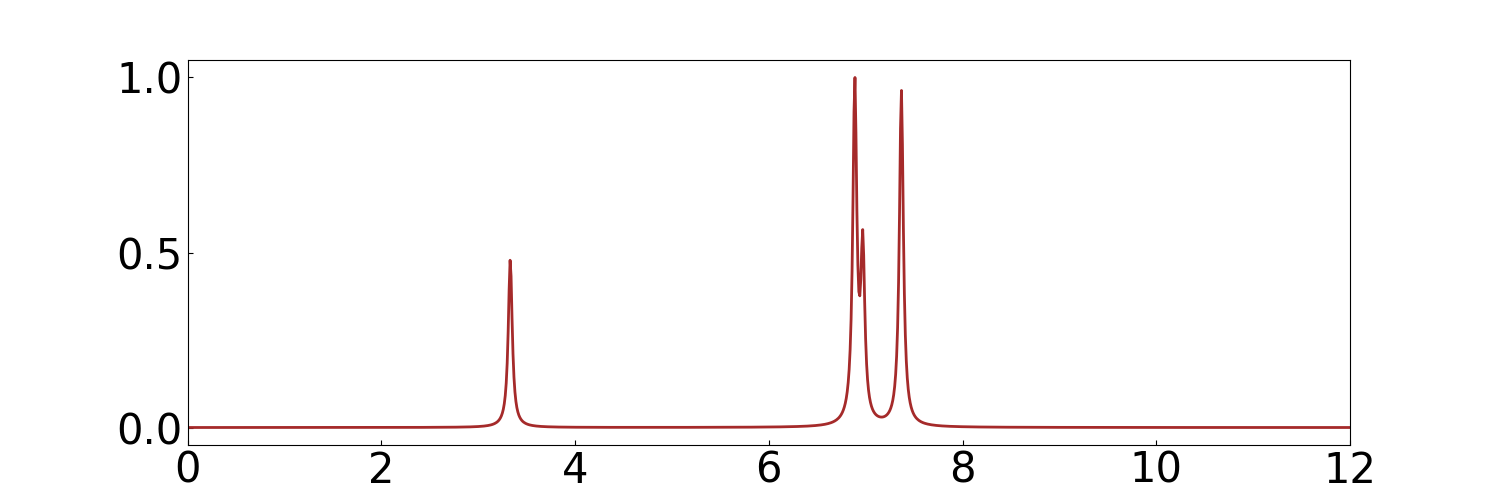

In [15]:
'''draw nmrh spectrum'''
plt.figure(figsize=(15,5))
plt.xlim(0,12)
plt.plot(xh,yh/yh.max(),lw=2,label='NMRH1',color='brown')
plt.show()

In [16]:
'''calculate uv spectrum'''
uv=uv_model_(z=z,pos=pos).detach().numpy()

<IPython.core.display.Javascript object>


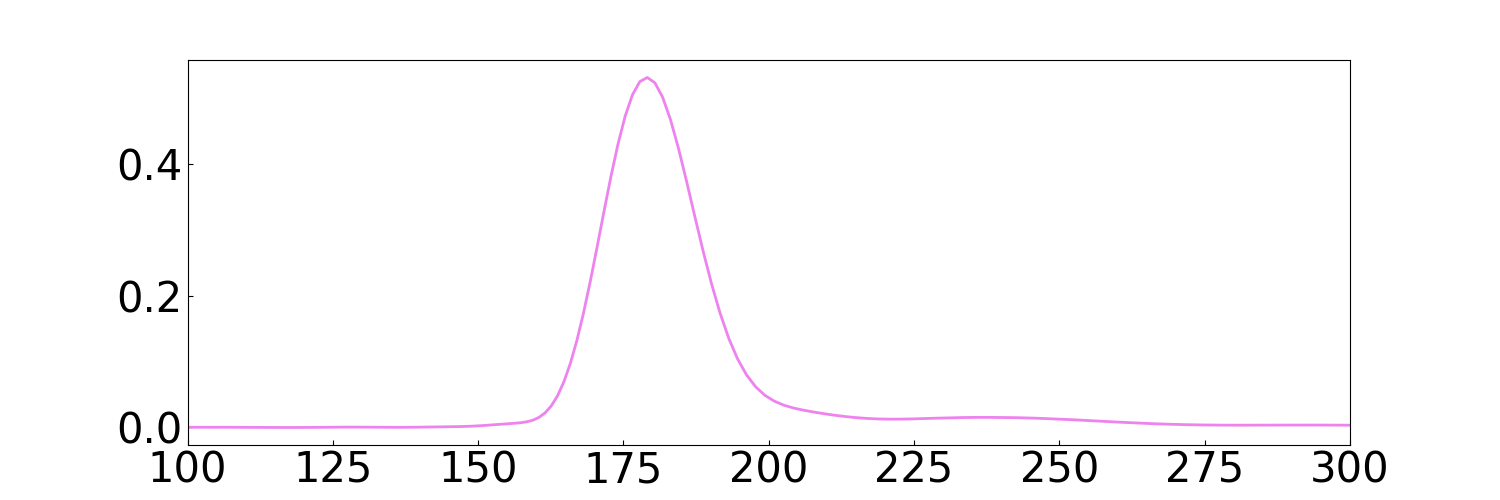

In [17]:
'''draw uv spectrum'''
xuv=1239.85/torch.linspace(1.5,13.5,240).detach().numpy()
plt.figure(figsize=(15,5))
plt.rc('font',family='Times New Roman', size=30)
plt.xlim(100,300)
plt.plot(xuv,uv,lw=2,color='Violet')